



# Histopathological Cancer Detection with Deep Neural Networks

*14 Apr 2019*

---

Being able to automate the detection of metastasised cancer in pathological scans with machine learning and deep neural networks is an area of medical imaging and diagnostics with promising potential for clinical usefulness. 

Here we explore a particular dataset prepared for this type of of analysis and diagnostics - The PatchCamelyon Dataset (PCam).

PCam is a binary classification image dataset containing approximately 300,000 labeled low-resolution images of lymph node sections extracted from digital histopathological scans. Each image is labelled by trained pathologists for the presence of metastasised cancer.

The goal of this work is to train a convolutional neural network on the PCam dataset and achieve close to, or near state-of-the-art results. 

As we'll see, with the Fastai library, we achieve 98.6% accuracy in predicting cancer in the PCam dataset.

We approach this by preparing and training a neural network with the following features:

1. Transfer learning with a convolutional neural net (Resnet50) as our backbone.
3. The following data augmentations:
    - Image resizing
    - Random cropping
    - Horizontal and vertical axis image flipping
4. Fit one cycle method to optimise learning rate selection for our training.
5. Discriminative learning rates to fine-tune.

In addition we apply the following out of the box optimisations throughout our training:
1. Dropout.
2. Batch normalisation.
3. Maxpooling.
4. ReLU activations.

This notebook presents research and an analysis of this dataset using Fastai + Pytorch and is provided as a reference, tutorial, and open source resource for others to refer to. It is not intended to be a production ready resource for serious clinical application. We work here instead with low resolution versions of the original high-res clincal scans in the Camelyon16 dataset for education and research. This proves useful ground to prototype and test the effectiveness of various deep learning algorithms.


## The Data 



<img style="float:left" src="https://camelyon16.grand-challenge.org/media/CAMELYON16/public_html/Low_Resolution.png/" width="200" />
<img style="float:left" src="https://camelyon16.grand-challenge.org/media/CAMELYON16/public_html/High_Resolution_2.png/" width="500" />


Examples above of a metastatic region (from Camelyon16)

#### Original Source: Camelyon16

PCam is actually a subset of the Camelyon16 dataset; a set of high resolution whole-slide images (WSI) of lymph node sections. This dataset is made available by the Diagnostic Image Analysis Group (DIAG) and Department of Pathology of the Radboud University Medical Center (Radboudumc) in Nijmegen, The Netherlands. The following is an excerpt from their website: <a href="https://camelyon16.grand-challenge.org/Data/" target="_blank">https://camelyon16.grand-challenge.org/Data/</a>   

> *The data in this challenge contains a total of 400 whole-slide images (WSIs) of sentinel lymph node from two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands).*

> *The first training dataset consists of 170 WSIs of lymph node (100 Normal and 70 containing metastases) and the second 100 WSIs (including 60 normal slides and 40 slides containing metastases).*

> *The test dataset consists of 130 WSIs which are collected from both Universities.*

#### PatchCam (Kaggle)

PCam was prepared by Bas Veeling, a Phd student in machine learning for health from the Netherlands, specifically to help machine learning practitioners interested in working on this particular problem. It consists of 327,680, 96x96 colour images. An excellent overview of the dataset can be found here: <a href="http://basveeling.nl/posts/pcam/" target="_blank">http://basveeling.nl/posts/pcam/</a>, and also available via download on github where there is further information on the data: <a href="https://github.com/basveeling/pcam" target="_blank">https://github.com/basveeling/pcam</a>

This particular dataset is downloaded directly from Kaggle through the Kaggle API, and is a version of the original PCam (PatchCamelyon) datasets but with duplicates removed. 

PCam is intended to be a good dataset to perform fundamental machine learning analysis. As the name suggests, it's a smaller version of the significanlty larger Camelyon16 dataset used to perform similar analysis (<a href="https://camelyon16.grand-challenge.org/Data/" target="_blank">https://camelyon16.grand-challenge.org/Data/</a>)

From the author's words:

> *PCam packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.*

---

### Hardware

We perform our training on an Ubuntu 18 machine with single RTX 2070 GPU using 16bit precision.

### Fast AI imports

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Set paths that you'll use in this notebook
root_dir = "/home/adeperio/"

# notebook project directories
base_dir = root_dir + 'ml/pcam/'
!mkdir -p "{base_dir}"

In [2]:
# set the random seed
np.random.seed(2)


## Kaggle SDK/API and downloading dataset
The data we are using lives on Kaggle. We use Kaggle's SDK to download the dataset directly from there. To work with the Kaggle SDK and API you will need to create a Kaggle API token in your Kaggle account. 

When logged into Kaggle, navigate to "My Account" then scroll down to where you can see "Create New API Token". This will download a JSON file to your computer with your username and token string. Copy these contents to you ~/.kaggle/kaggle.json token file.

In [ ]:
# First we make sure we have the kaggle sdk installed.
# We assume here that on your machine you have the kaggle.json token file in ~/.kaggle/
!pip install kaggle

#### Kaggle API: Download Competition Data

In [ ]:
# Can list available Kaggle competitions here if needed
# !kaggle competitions list

# Download the histopathological data
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

In [ ]:
#now unzip the training files
!mkdir -p "{base_dir}train/"
dest_dir_train = Path(base_dir + 'train/')
print(base_dir + 'train.zip')
train_zip = zipfile.ZipFile(base_dir + 'train.zip', 'r')
train_zip.extractall(dest_dir_train)
train_zip.close()

In [ ]:
#now unzip the test files
!mkdir -p "{base_dir}test/"
dest_dir_test = Path(base_dir + 'test/')
test_zip = zipfile.ZipFile(base_dir + 'test.zip', 'r')
test_zip.extractall(dest_dir_test)
test_zip.close()
  

In [ ]:
# then extract the labels 
dest_dir_csv = Path(base_dir)
labels_csv_zip = zipfile.ZipFile(base_dir + 'train_labels.csv.zip', 'r')
labels_csv_zip.extractall(dest_dir_csv)
labels_csv_zip.close()

In [4]:
# Check the download here
path = Path(base_dir)
path.ls()

[PosixPath('/home/adeperio/ml/pcam/test'),
 PosixPath('/home/adeperio/ml/pcam/.ipynb_checkpoints'),
 PosixPath('/home/adeperio/ml/pcam/pcam-ml-ubuntu.ipynb'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50-unfrozen.pth'),
 PosixPath('/home/adeperio/ml/pcam/stage-1.pth'),
 PosixPath('/home/adeperio/ml/pcam/train_labels.csv'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50.pth'),
 PosixPath('/home/adeperio/ml/pcam/test.txt'),
 PosixPath('/home/adeperio/ml/pcam/models'),
 PosixPath('/home/adeperio/ml/pcam/train'),
 PosixPath('/home/adeperio/ml/pcam/sample_submission.csv.zip'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-34.pth'),
 PosixPath('/home/adeperio/ml/pcam/train_labels.csv.zip'),
 PosixPath('/home/adeperio/ml/pcam/train.zip'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50-1.pth'),
 PosixPath('/home/adeperio/ml/pcam/test.zip')]

## Data Preparation

With our data now downloaded, we create an ImageDataBunch object to help us load the data into our model, set data augmentations, and split our data into train and test sets.

In [3]:
tfms = get_transforms(do_flip=True, max_warp=0.)

In [4]:
bs=128 # also the default batch size
data = ImageDataBunch.from_csv(
    base_dir, 
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

ImageDataBunch wraps up a lot of functionality to help us prepare our data into a format that we can work with when we train it. Let's go through some of the key functions it performs below:

### Data Augmentation

By default ImageDatabunch performs a number of modifications and augmentations to the dataset:

1. Centre crop the images
2. There's also some randomness introduced on where and how it crops for the purposes of data augmentation
4. It's important that all the images need to be of the same size for the model to be able to train on. 

*Image Flipping*

There are various other data augmentations we could also use. But one of the key ones that we activate is image flipping on the vertical.

For pathology scans this is a reasonable data augmentation to activate, as there is little importance on whether the scan is oriented on the vertical axis or horizontal axis, 

By default fastai will flip on the horizontal, but we need to turn on flipping on the vertical. 

### Batch Size

We'll be using the 1cycle policy (fit_one_cycle()) to train our network (more on this later). This is a hyper parameter optimisation that allows us to use higher learning rates.

Higher learning rates acts as a form of regularisation in 1cycle policy. Recall that a small batch size adds regularisation, so when using large batch sizes in 1cycle learning it allows for larger learning rates to be used.

The recommendation here is to use a batch size that is the largest our GPU supports when using 1cycle policy to train.

### Training, validation and test sets

1.   We specify the folder location of the data (where the subfolders train and test exist along with the csv data)
2.   ImageDataBunch under the hood splits out the images (in the train sub-folder) into a training set and validation set (defaulting to an 80/20 percent split). There are 176,020 images in the training set and about 44,005 in the validation set. 
3.   We also specify the location of the test sub-folder, that contains unlabelled images. Our learning model will measure accuracy and the error rates against this dataset
4. The CSV file containing the data labels is also specified

### Image size on base architecture and target architecture

Images in the target PCam dataset are square images 96x96. However, when bringing a pre-trained ImageNet model into our network, which was trained on larger images, we need to set the size accordingly to respect the image sizes in that dataset. 

We choose 224 for size as a good default to start with. 



### Normalising the images

Once we have setup the ImageDataBunch object, we also **normalise** the images. 

Normalising the images uses the **mean** and **standard deviation** of the images to transform the image values into a standardised distribution that is more efficient for a neural network to train on. 

In [5]:
# now normalise the images
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,1
Path: /home/adeperio/ml/pcam;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/adeperio/ml/pcam;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/adeperio/ml/pcam

Below we take a look at some random samples of the data so we can get some understanding of what we are feeding into our network. This is a binary classification problem so there's only two classes (0 - 1) 

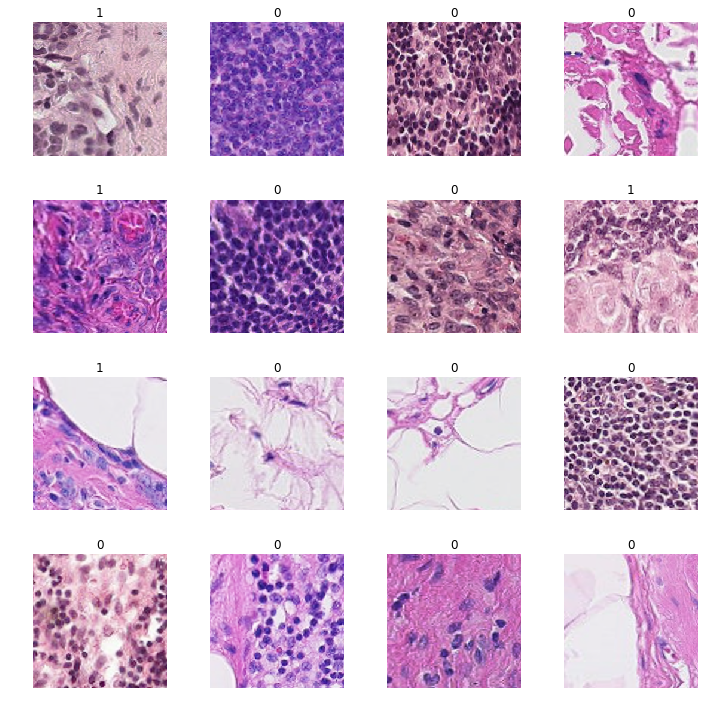

In [8]:
data.show_batch(rows=4, figsize=(10, 10))

## Learner (CNN Resnet50)

Once we have a correctly setup the ImageDataBunch object, we can now pass this, along with a pre-trained ImageNet model, to a cnn_learner. We will be using Resnet50 as our backbone.

In [6]:
# I am using a GPU that supports 16bit precision, so we also switch this support mode to on. 
# If your GPU does not have that support you can omit the to_fp16() call
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph).to_fp16()

Fastai wraps up a lot of state-of-the-art computer vision learning in its cnn_learner:

- Connects our pre-trained model with a layer group of fully connected layers.
- ReLU activations
- Batch normalisation
- Max pooling
- Drop out

Importantly, we also specify a backbone network, that has been pre-trained on the ImageNet dataset, so that we can use transfer learning in our training.


### Transfer learning

Starting with a backbone network from a well-performing model that was already pre-trained on another dataset is a method called *transfer learning*. 

Transfer learning works on the premise that instead of training your data from scratch, you can use the learning (ie the learned weights) from another machine learning model as a starting point. 

>*This is an incredibly effective method of training, and underpins current state-of-the-art practices in training deep neural networks.*

When using pre-trained models we leverage, in particular, the learned features that are most in common with both the pre-trained model and the target dataset (PCam).

So for example, for models pre-trained on ImageNet such as Resnet50, training will leverage the common features (for example such as lines, geometry, patterns) that have already been learnt from the base dataset (in particular in the first few layers) to train on the target dataset. 

For our model, we'll be using Resnet50. Resnet50 is a residual neural net trained on ImageNet data using 50 layers, and will provide a good starting point for our network. 

Using learn.model we can see the various layers and elements of the neural network that are used. 


In [7]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

## Training and fit one cycle


### Fit one cycle

We will be training our network with a method called fit one cycle. This optimisation is a way of applying a variable learning rate across the total number of epochs in our training run for a particular layer group. This has proven to be an extremely effective way to tune the learning rate hyperparamter for training. 

Fit one cycle varies the learning rate from a minimum value at the first epoch (by default lr_max/div_factor), up to a pre-determined maximum value (lr_max), before descending again to a minimum across the remaining epochs. This min-max-min learning rate variance is called a cycle.

An excellent overview can be found here in the fastai docs <a href="https://docs.fast.ai/callbacks.one_cycle.html" target="_blank">https://docs.fast.ai/callbacks.one_cycle.html</a> along with a more detailed explanation in the original paper by Leslie Smith [7], where this method of hyperparameter tuning was proposed. 

So how then do we determine the most suitable maximum learning rate to enable fit one cycle? We run fastai's lr_find() method.

Running lr_find before unfreezing the network yields the graph below. We want to choose a learning rate just before the loss starts to exponetially increase.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


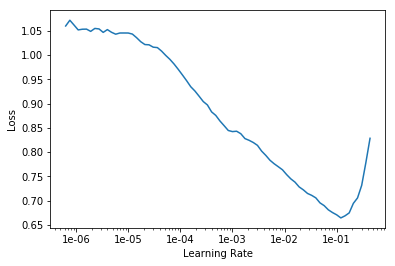

In [8]:
learn.lr_find()
learn.recorder.plot()

From a visual observation of the resulting learning rate plot, starting with a learning rate of 1e-02 seems to be a reasonable choice for an initial lr value. 

In [9]:
lr=1e-02

### Freeze

By default we start with our network *frozen*. This means that the layers of our pre-trained Resnet50 model have trainable=False applied, and training begins only on the target dataset. The learning rate we provide to fit_one_cycle() applies only to that layer group for this initial training run.


epoch,train_loss,valid_loss,error_rate,time
0,0.231337,0.201674,0.078582,09:41
1,0.182387,0.151659,0.055653,09:34
2,0.172682,0.131761,0.047154,09:34


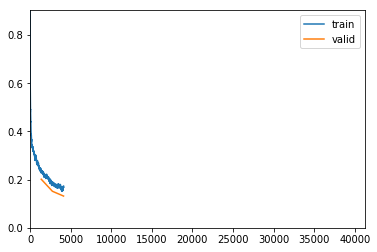

In [ ]:
learn.fit_one_cycle(30, slice(lr))

In [ ]:
learn.save(base_dir + 'pcam-v2-stage-1')

In [ ]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

### Analysing first results

Analysing the graph of the initial training run, we can see that the training loss and validation loss both steadily decrease and begin to converge while the training progresses. 

With the validation loss steadily decreasing, there are no clear signs of significant overfitting or underfitting. 

Accuracy at the moment is 97.76%.

We can learn more about this training run by using Fastai's confusion matrix.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

The confusion matrix is a handy tool to help us obtain more detail on the effectiveness of the training so far. Specifically, we get some clarity on the amount of false positives and false negatives predicted by our neural net. 

## Fine-tuning, unfreezing, and discriminative learning rates

Initial results are already good on the first training run. But with some more fine-tuning, we can actually do a little better. 

### Transfer learning + Fine-tuning = Better Generalisation

Transfer learning alone brings us much further than training our network from scratch. But this method is prone to optimisation difficulties present between *fragile co-adpated* layers when connecting a per-trained network. We counter this by fine-tuning our model; making the all layers of our network, including the pre-trained Resnet50 layers, to be trainable. When we unfreeze we train across all of our layers. (See [6])

This leads to better results and a better ability to generalise to new examples.


### Discriminative Learning Rates and 1cycle 

With all of our layers in our network unfrozen and open for training, we can now also make use of *discriminative learning rates* in conjunction with fit_one_cycle to improve our optimisations even further.

Discriminative learning rates lets us apply specific learning rates to layer groups in our network, optimising for each group. Fit one cycle then operates on these values and uses them to vary learning rates according to the 1cycle policy. (<a href="https://docs.fast.ai/basic_train.html#Discriminative-layer-training" target="_blank">https://docs.fast.ai/basic_train.html#Discriminative-layer-training</a>)

How do we find the best range of learning rates to use for fit 1cycle? We can use lr_find() to help us with that.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


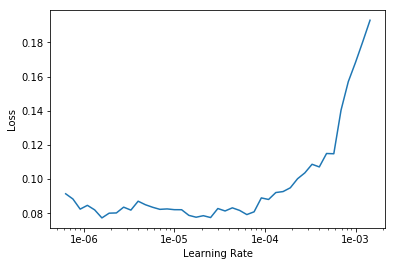

In [65]:
# Using the plot from the learning rate finder above, 
# find a value for the first value in the max_lr slice 
# that is well before the point when the loss start to significantly degrade
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()


Analysing our lr plot above, we choose a range of learning rates just before the loss begins to radically increase and apply that as a slice to our fit_one_cycle method below. 

From our plot above, it seems reasonable to select an upper bound rate of 1e-4, and as a recommended rule for our lower bound rate, we can select a value 10x smaller than our upperbound, in this case 1e-5.

The lower bound rate will apply to the layers in our pre-trained Resnet50 layer group. The weights here are already well learned so we can proceed with a slower learning rate for this group of layers. 

The upper bound rate gets applied to the final layer group of fully connected layers previously trained in our last training run on the target dataset. The layers in this group will benefit from a faster learning rate. 

epoch,train_loss,valid_loss,error_rate,time
0,0.068424,0.066296,0.021475,13:17
1,0.085035,0.068620,0.022861,13:19
2,0.077056,0.072795,0.024724,13:19
3,0.082423,0.076358,0.025315,13:22
4,0.094262,0.075467,0.025202,13:19
5,0.089292,0.095523,0.031724,13:21
6,0.082299,0.069068,0.022634,13:21
7,0.085847,0.074969,0.025293,13:20
8,0.067565,0.072602,0.023634,13:21
9,0.082363,0.066331,0.022520,13:21


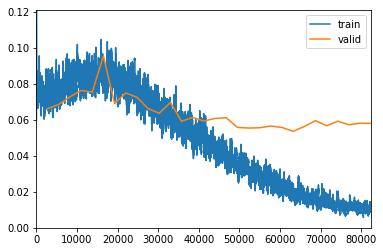

In [66]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,lr/5))
learn.recorder.plot_lr()

In [67]:
learn.save(base_dir + 'pcam-v2-stage-2')

In [8]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 98.59561157226562 %.


### Final analysis

In the final fine-tuning training run, we can see that our training loss and validation loss begin to diverge from each other now mid training, and that the training loss is progressively improving at a much faster rate than validation loss, steadily decreasing until stabilising to a steady range of values in the final epochs of the run.

Any further increases in our validation loss, in the presence of a continually decreasing training loss, would result in overfitting, failing to generalise well to new examples. Training for too long would risk this.

Finalising the at this point in our training yields a fine-tuned accuracy of 98.6% over our stage 1 training run result.



## Conclusion

With an approach using deep convolutional neural networks, transfer learning, and fit one cycle optimisations, we can achieve 98.6% accuracy on detecting cancer in the PCam dataset. 

## References

[1] Practical Deep Learning for Coders, v3. Fastai. Jeremy Howard. Rachel Thomson. <a href="https://course.fast.ai/index.html" target="_blank">https://course.fast.ai/index.html</a>

[2] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[3] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

[4] Camelyon16 Challenge <a href="https://camelyon16.grand-challenge.org" target="_blank">https://camelyon16.grand-challenge.org</a>  

[5] Kaggle. Histopathologic Cancer Detection - Identify metastatic tissue in histopathologic scans of lymph node sections <a href="https://www.kaggle.com/c/histopathologic-cancer-detection" target="_blank">https://www.kaggle.com/c/histopathologic-cancer-detection</a>

[6] Jason Yosinski. Jeff Clune. Yoshua Bengio. Hod Lipson. "How transferable are features in deep neural networks?
". arXiv:1411.1792v1 [cs.LG] 

[7] Leslie N. Smith. "A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay". arXiv:1803.09820v2 [cs.LG]